# **합성곱 신경망 I**

### **[개념 정리]**

#### **5.2 합성곱 신경망 맛보기**

fashion_mnist 데이터셋 사용
> 훈련 데아터(train_images): [0, 255]의 값을 갖는 28 x 28 크기의 넘파이 배열
> 레이블(정답) 데이터(train_labels): 0에서 9까지 정수 값을 갖는 배열
> - 0 : T-Shirt
> - 1 : Trouser
> - 2 : Pullover
> - 3 : Dress
> - 4 : Coat
> - 5 : Sandal
> - 6 : Shirt
> - 7 : Sneaker
> - 8 : Bag
> - 9 : Ankle Boot

`nn.Sequential`
> 1. __ init __()에서 사용할 네트워크 모델 정의
> 2. forward() 함수에서 구현될 순전파를 계층 형태로 코드 작성
- 즉, 계층을 차례로 쌓을 수 있도록 $Wx + b$와 같은 수식과 활성화 함수를 연결해 주는 역할

`nn.Conv2d`
> 1. in_channels: 입력 채널의 수
> 2. out_channels: 출력 채널의 수
> 3. kernel_size: 커널/필터 크기
> 4. padding: 패딩 크기, 출력 크기 조정을 위해 입력 데이터 주위에 0을 채움

`nn.BatchNorm2d`
> 학습 과정에서 각 배치 단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용하여 정규화하는 것

`nn.MaxPool2d`
> 이미지 크기를 축소시키는 용도
> 1. kernel_size: m x n 행렬로 구성된 가중치
> 2. stride: 입력 데이터에 커널을 적용할 때, 이동할 간격
> - 스트라이드 값이 커지면 출력 크기 감소

`nn.Linear`
> 1. in_features: 입력 데이터의 크기
> 2. out_features: 출력 데이터의 크기



### **[필사]**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
train_dataset = torchvision.datasets.FashionMNIST("/content/sample_data", download=True,
                                                  transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("/content/sample_data", download=True,
                                                 train=False, transform=transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 272kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.02MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 23.2MB/s]


In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

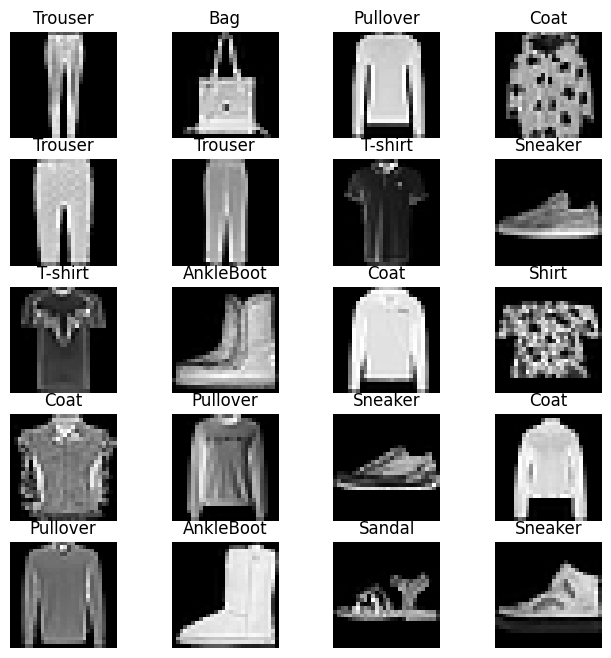

In [6]:
labels_map = {0:'T-shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal',
              6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'AnkleBoot'}

fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows+1):
  img_xy = np.random.randint(len(train_dataset));
  img = train_dataset[img_xy][0][0,:,:]
  fig.add_subplot(rows, columns, i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')
plt.show()

심층 신경망 모델 생성

In [7]:
class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(in_features=784, out_features=256)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features=256, out_features=128)
    self.fc3 = nn.Linear(in_features=128, out_features=10)

  def forward(self, input_data):
    out = input_data.view(-1, 784)
    out = F.relu(self.fc1(out))
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

심층 신경망에서 필요한 파라미터 정의

In [8]:
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


심층 신경망을 이용한 모델 학습

In [9]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct * 100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

  if not (count % 500):
    print("Iteration: {}, Loss:{}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 3000, Loss:0.2528078258037567, Accuracy: 86.69999694824219%


합성곱 네트워크 생성

In [15]:
class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.fc3 = nn.Linear(in_features=120, out_features=10) # 마지막 계층의 out_features는 클래스 개수

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0),-1) # 완전연결층으로 전달하기 위해 1차원으로 변경
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

합성곱 네트워크를 위한 파라미터 정의

In [16]:
learning_rate = 0.001
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss(); # 분류에서 사용하는 손실 함수
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate) # Adam 경사 하강법 사용
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [17]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))

        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()

        total += len(labels)

      accuracy = correct * 100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

      if not (count % 500):
        print('Iteration: {}, Loss: {}, Accuracy: {}%'.format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.532809853553772, Accuracy: 88.12999725341797%
Iteration: 1000, Loss: 0.36158761382102966, Accuracy: 87.63999938964844%
Iteration: 1500, Loss: 0.25699344277381897, Accuracy: 89.2300033569336%
Iteration: 2000, Loss: 0.22739920020103455, Accuracy: 88.86000061035156%
Iteration: 2500, Loss: 0.13394656777381897, Accuracy: 90.06999969482422%
Iteration: 3000, Loss: 0.22535043954849243, Accuracy: 89.97000122070312%
